In [63]:
import numpy as np
import pandas as pd
import torch.nn as nn
from torch import optim
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [40]:
piece_values = { # the heuristic evaluation of each piece
    'p': -1, 'P': 1,
    'n': -3, 'N': 3,
    'b': -3, 'B': 3,
    'r': -5, 'R': 5,
    'q': -9, 'Q': 9,
    'k': -20, 'K': 20,
    '.': 0
}

class ChessDataset(Dataset): # dataset class for the chess data
    def __init__(self): # initialize the dataset
        self.data = pd.read_csv("chessData.csv", names=['FEN', 'Evaluation']) # read the data
        self.fens = self.data.FEN.values # get the FENs
        self.evaluations = self.data.Evaluation.values # get the evaluations
        self.min_evaluation = -1000 # the minimum evaluation
        self.max_evaluation = 1000 # the maximum evaluation

    def __len__(self): # get the length of the dataset in order to iterate through it
        return len(self.fens)

    def __getitem__(self, idx): # get the item at the given index
        fen = self.fens[idx]
        evaluation = self.evaluations[idx]

        try:
            # encode the FEN
            fen_encoded = one_hot_encoder(fen).reshape(-1).astype(np.float32) 
        except ValueError as e: 
            print(f"Invalid FEN string: {fen}") # prints error message if the FEN is invalid
            fen_encoded = np.zeros((1, 8, 8), dtype=np.float32)  # example default value of encoded FEN string

        evaluation_scaled = scale_evaluation(evaluation, self.min_evaluation, self.max_evaluation) # scale the evaluation

        return fen_encoded, evaluation_scaled

def one_hot_encoder(fen): # one hot encodes the FEN
    try:
        board_layout = fen.split()[0]
        encoded = []

        for char in board_layout:
            if char.isdigit():  # if the character is a number then we need to add that many empty spaces
                encoded.extend([piece_values['.']] * int(char))
            elif char in piece_values:  # if the character is a piece then we add it to the encoded board and use the heuristic values in the beginning of this code chunk
                encoded.append(piece_values[char])

        if len(encoded) != 64: # if the length of the FEN string is not 64 then we have an invalid FEN string
            raise ValueError(f"Invalid FEN string: {fen}")

        return np.array(encoded, dtype=np.float32).reshape(1, 8, 8) # return the encoded FEN string

    except Exception as e:
        print(f"Error processing FEN string: {fen}, Error: {e}")
        return np.zeros((1, 8, 8), dtype=np.float32)  # Return a default value in case of error


def scale_evaluation(evaluation, min_evaluation, max_evaluation):
    # Handle special evaluation strings for checkmate or decisive advantage/disadvantage
    if isinstance(evaluation, str) and evaluation.startswith('#'):
        if evaluation[1] == '+':
            evaluation_scaled = 1.0  # Indicating a decisive advantage or imminent checkmate for white
        elif evaluation[1] == '-':
            evaluation_scaled = 0.0  # Indicating a decisive disadvantage or imminent checkmate for black
        else:
            evaluation_scaled = 0.5  # Default case for unexpected formats
    else:
        try:
            # Standard numeric evaluation
            evaluation = float(evaluation)
            evaluation = min(max(evaluation, min_evaluation), max_evaluation)
            evaluation_scaled = (evaluation - min_evaluation) / (max_evaluation - min_evaluation)
        except ValueError:
            # If conversion fails, set a default value or handle it as needed
            evaluation_scaled = 0.5  # Default value, adjust as needed

    return evaluation_scaled

In [ ]:
# The model takes on inspiration from the following github contributor; https://github.com/geohot/twitchchess - George Hotz is a well known programmer. He is the founder of comma.ai and also undertaking creating a new open source deep learning library, tinygrad. 

dataset = ChessDataset() # load the dataset

device = "cuda" if torch.cuda.is_available() else "cpu" # use gpu if available, otherwise use cpu -> originally we wanted to use google colab, but it was actually slower than our cpu. It might have something to with the the internet connection.

train_loader = DataLoader(dataset, batch_size = 32, shuffle = True) # load the data into a dataloader, which is used to train the model.


model = nn.Sequential( # setting up the architecture of the model
    nn.Linear(8 * 8, 16),  # input layer
    nn.ReLU(),
    nn.Linear(16, 16),  # hidden layer
    nn.ReLU(),
    nn.Linear(16, 1)  # output layer
)

optimizer = optim.NAdam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, momentum_decay=4e-3) # usage of NAdam optimization strategy, the values are default values, but we wanted to show what they actually are. Also we call the optimizer on the model parameters.

criterion = nn.MSELoss() # specifices the loss function, in this case we use the mean squared error loss function.

gradient_norms = {'epoch': [], 'layer': [], 'grad_norm': []} # stores the epoch number, layer number and the gradient norm for each layer

for epoch in range(50): # iteration process over 50 epochs
    model = model.to(device).float() # move the model to the device (cpu or gpu)
    for i, (fen_encoded, evaluation) in enumerate(train_loader): # iterate over the data
        fen_encoded = fen_encoded.to(device).float().view(-1, 64)  # reshape to batch_size x 64
        evaluation = evaluation.to(device).float() # move the data to the device (cpu or gpu)

        optimizer.zero_grad() # inititalize the gradients to zero for each iteration
        output = model(fen_encoded) # forward pass
        output = output.view(-1) # reshape the output to a vector
        loss = criterion(output, evaluation) # calculate the loss

        if torch.isnan(loss): # if the loss is nan, skip the update
            print("Encountered nan loss, skipping the update.")
            continue

        loss.backward() # backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clips the gradients to a maximum norm of 1.0, to prevent exploding gradients -> also to show the gradient magnitude instead of the direction
        optimizer.step() # update the parameters according to the optimizer strategy
 
        for layer_idx, param in enumerate(model.parameters()): # iterate over the layers and store the gradient norms
            if param.grad is not None: # if the gradient is not none, store the gradient norm
                gradient_norms['epoch'].append(epoch) # store the epoch number
                gradient_norms['layer'].append(layer_idx) # store the layer number
                gradient_norms['grad_norm'].append(param.grad.norm().item()) # store the gradient norm

        if i % 50 == 0: # print the loss every 50 iterations
            print(f'Epoch: [{epoch + 1}/50], Step: [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), 'model.pth') # save the model

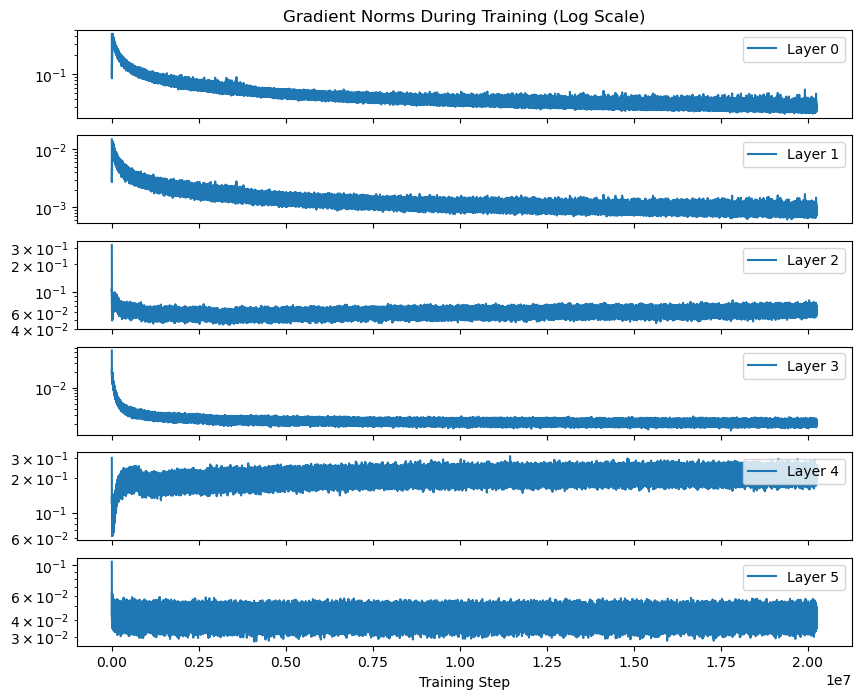

In [50]:
def moving_average(x, w): # function to smooth the gradients by averaging over a window of 100 steps, as specified below in the code
    return np.convolve(x, np.ones(w), 'valid') / w

num_layers = len(set(gradient_norms['layer'])) # get the number of layers
fig, axs = plt.subplots(num_layers, 1, figsize=(10, 8), sharex=True) # create a figure with subplots

for layer_idx in range(num_layers): # iterate over the layers
    layer_grads = [gn for l, gn in zip(gradient_norms['layer'], gradient_norms['grad_norm']) if l == layer_idx] # get the gradients for the current layer
    smooth_grads = moving_average(layer_grads, 100) # smooth the gradients by averaging over 100 steps
    
    axs[layer_idx].plot(smooth_grads, label=f'Layer {layer_idx}')
    axs[layer_idx].set_yscale('log')  # sets the y-axis to a logarithmic scale
    axs[layer_idx].legend(loc='upper right') # positions the legend in the upper right corner of the plot

plt.xlabel('Training Step') # sets the x label
axs[0].set_title('Gradient Norms During Training (Log Scale)') # sets the title for the plot
plt.show() # shows the plot

In [68]:
class ChessEvalDataset(Dataset): # dataset class for the chess evaluation data
    def __init__(self, csv_file): # initialize the dataset
        self.data = pd.read_csv("random_evals.csv", names=['FEN', 'Evaluation']) # read the data
        self.fens = self.data.FEN.values # get the FENs
        self.evaluations = self.data.Evaluation.values # get the evaluations

    def __len__(self): # get the length of the dataset in order to iterate through it
        return len(self.fens)

    def __getitem__(self, idx): # get the item at the given index
        fen = self.fens[idx]
        evaluation = self.evaluations[idx]

        try:
            fen_encoded = one_hot_encoder(fen).reshape(-1).astype(np.float32) # encode the FEN
        except ValueError as e: # prints error message if the FEN is invalid
            print(f"Invalid FEN string: {fen}")
            fen_encoded = np.zeros((1, 8, 8), dtype=np.float32)

        evaluation_scaled = scale_evaluation(evaluation, -1000, 1000) # scale the evaluation

        return fen_encoded, evaluation_scaled

# Load evaluation data
eval_dataset = ChessEvalDataset("random_evals.csv") # load the dataset
eval_loader = DataLoader(eval_dataset, batch_size=32) # load the data into a dataloader, which is used to evaluate the model.

In [72]:
# make sure the model is loaded, when the model is saved the architecture is NOT saved, only the parameters. Therefore we need to define the model again and load the parameters.

model = nn.Sequential(
    nn.Linear(8 * 8, 16),  # input layer
    nn.ReLU(),
    nn.Linear(16, 16),  # hidden layer
    nn.ReLU(),
    nn.Linear(16, 1)  # output layer
)

model.load_state_dict(torch.load('model.pth')) # load the model

model.eval() # set the model to evaluation mode
predictions = [] # initialize the predictions list
targets = [] # initialize the targets list
total_loss = 0 # initialize the total loss to zero

with torch.no_grad():  # disable gradient calculation for evaluation
    for fen_encoded, evaluation in eval_loader: # iterate over the data
        fen_encoded = fen_encoded.to(device).float().view(-1, 64) # reshape to batch_size x 64
        evaluation = evaluation.to(device).float() # move the data to the device (cpu or gpu)

        output = model(fen_encoded) # forward pass
        output = output.view(-1) # reshape the output to a vector
        loss = criterion(output, evaluation) # calculate the loss
        total_loss += loss.item() # add the loss incrementally to the total_loss
        predictions.extend(output.tolist()) # add the predictions to the predictions list
        targets.extend(evaluation.tolist()) # add the targets to the targets list

predictions = np.array(predictions) # convert the predictions list to a numpy array
targets = np.array(targets) # convert the targets list to a numpy array

average_loss = total_loss / len(eval_loader) # calculate the average loss
rmse = np.sqrt(mean_squared_error(predictions, targets)) # calculate the root mean squared error
mae = mean_absolute_error(predictions, targets) # calculate the mean absolute error
r2 = r2_score(predictions, targets) # calculate the R2 score

print(f"Average loss on evaluation dataset: {average_loss:.4f}") # print the average loss
print(f"RMSE on evaluation dataset: {rmse:.4f}") # print the root mean squared error
print(f"MAE on evaluation dataset: {mae:.4f}") # print the mean absolute error
print(f"R2 on evaluation dataset: {r2:.4f}") # print the R2 score

Error processing FEN string: FEN, Error: Invalid FEN string: FEN
Average loss on evaluation dataset: 0.0712
RMSE on evaluation dataset: 0.2669
MAE on evaluation dataset: 0.2069
R2 on evaluation dataset: -2.6563
